# Monthly OMI NO2 time series using rioxarray and stackstac {.unnumbered}

This notebook demonstrates how to generate a timeseries via `rioxarray`, `satsarch` and `stackstac`.

* Author: Aimee Barciauskas
* Lasted Updated Date: May 13, 2022

In [1]:
import rioxarray
import stackstac
from satsearch import Search

## Use satsearch to discover items in the no2-monthly collection for China

In [2]:
stac_api_url = 'https://staging-stac.delta-backend.xyz/'
china_bbox = [
    73.675,
    18.198,
    135.026,
    53.459
]
datetime = "2000-01-01T00:00:00Z/2022-01-02T00:00:00Z"
collection = 'no2-monthly'

search = Search.search(
    url=stac_api_url,
    bbox=china_bbox,
    datetime=datetime,
    collections=[collection],
    limit=1000
)
items = search.items()

In [3]:
len(items)

73

## Create an `xarray.DataArray` using `stackstac`

In [11]:
stack = stackstac.stack(items)
stack

,Array,Chunk
Bytes,3.52 GiB,8.00 MiB
Shape,"(73, 1, 1800, 3600)","(1, 1, 1024, 1024)"
Count,730 Tasks,584 Chunks
Type,float64,numpy.ndarray


## Clip the data to the bounding box for China

In [6]:
# Subset to Bounding Box for China
subset = stack.rio.clip_box(
    minx=china_bbox[0],
    miny=china_bbox[1],
    maxx=china_bbox[2],
    maxy=china_bbox[3]
)
subset

,Array,Chunk
Bytes,121.06 MiB,1.44 MiB
Shape,"(73, 1, 354, 614)","(1, 1, 354, 535)"
Count,876 Tasks,146 Chunks
Type,float64,numpy.ndarray


## Select a band of data

There is just one band in this case, `cog_default`.

In [7]:
# select the band default
data_band = subset.sel(band='cog_default')
data_band

<xarray.DataArray 'stackstac-0e5c1d761e250551f505585d46ddfff0' (time: 73,
                                                                y: 354, x: 614)>
dask.array<getitem, shape=(73, 354, 614), dtype=float64, chunksize=(1, 354, 535), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2016-01-01 2016-02-01 ... 2022-01-01
    id              (time) <U46 'OMI_trno2_0.10x0.10_201601_Col3_V4-no2-month...
    band            <U11 'cog_default'
  * x               (x) float64 73.7 73.8 73.9 74.0 ... 134.7 134.8 134.9 135.0
  * y               (y) float64 53.5 53.4 53.3 53.2 53.1 ... 18.5 18.4 18.3 18.2
    proj:geometry   object {'type': 'Polygon', 'coordinates': [[[-180.0, 90.0...
    proj:epsg       int64 4326
    proj:bbox       object {90.0, 180.0, -90.0, -180.0}
    proj:shape      object {1800, 3600}
    proj:transform  object {0.1, 0.0, 1.0, -0.1, -180.0, 90.0}
    epsg            int64 4326
    spatial_ref     int64 0
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-180.0, -90.0, 180.0, 90.0), r...
    resolution:  0.1

In [8]:
# Group data into months
dates = data_band.groupby('time')

In [9]:
# Average over entire spatial bounding box for each month
means = dates.mean(dim=('x', 'y'))

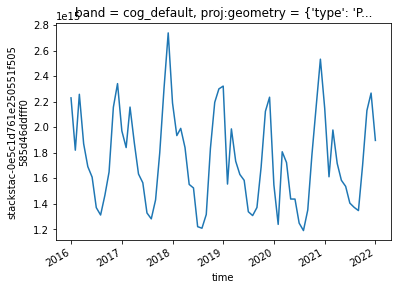

In [10]:
means.plot()